# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input/R5KrjnANiKVhLWAkpXhNBe'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.85KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

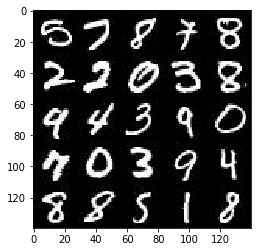

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

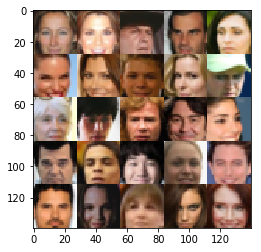

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    image_shape = (image_width, image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, *image_shape), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    
    alpha = 0.1

    def conv2d(x, out_dim, k=5, s=2, padding='same', use_batch_norm=True, training=True):
        layer = tf.layers.conv2d(x, out_dim, k, s, padding)
        if use_batch_norm == True:
            layer = tf.layers.batch_normalization(layer, training=training)
        layer = tf.maximum(alpha*layer, layer)
        return layer

    with tf.variable_scope('discriminator', reuse=reuse):
        layer_1 = conv2d(images, 32, use_batch_norm=False, training=False) # => 14x14x32                       
        layer_2 = conv2d(layer_1,  64)  # => 7 x 7x 64
        layer_3 = conv2d(layer_2, 128)  # => 4 x 4x128 
        layer_4 = conv2d(layer_3, 256)  # => 2 x 2x256

        flat = tf.reshape(layer_4, (-1, 2*2*256))

        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    # TODO: Implement Function
    
    alpha = 0.1

    def fully_connect(x, dims, training):
        layer = tf.layers.dense(x, dims[0]*dims[1]*dims[2])
        layer = tf.reshape(layer, (-1, dims[0], dims[1], dims[2]))
        layer = tf.layers.batch_normalization(layer, training=training)
        layer = tf.maximum(alpha*layer, layer)
        return layer

    def conv2d_transpose(x, out_dim, k=5, s=2, padding='same', 
                         use_batch_norm=True, use_leaky_relu=True, training=True):
        layer = tf.layers.conv2d_transpose(x, out_dim, k, s, padding)
        if use_batch_norm == True:
            layer = tf.layers.batch_normalization(layer, training=training)
        if use_leaky_relu == True:
            layer = tf.maximum(alpha*layer, layer)
        return layer

    with tf.variable_scope('generator', reuse=not is_train):
        layer_1 = fully_connect(z, (4, 4, 512), is_train)           # => 4x4x512
        layer_2 = conv2d_transpose(layer_1, 128, k=4, s=1, 
                                   padding='valid',
                                   training=is_train)               # => 7x7x128  
        layer_3 = conv2d_transpose(layer_2, 64, training=is_train)  # => 14x14x64
        layer_4 = conv2d_transpose(layer_3, 32, training=is_train)  # => 28x28x32 

        logits = conv2d_transpose(layer_4, out_channel_dim, 3, 1, 
                                  'same', False, False, True)       # => 28x28x3(1)

        output = tf.tanh(logits)

        return output
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    def get_loss(logits, labels):
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, 
                                                                      labels=labels))

    d_loss_real = get_loss(d_logits_real, tf.ones_like(d_model_real))
    d_loss_fake = get_loss(d_logits_fake, tf.zeros_like(d_model_fake))
    g_loss = get_loss(d_logits_fake, tf.ones_like(d_model_fake))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
                        .minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
                        .minimize(g_loss, var_list=g_vars)    

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
     
    # TODO: Build Model    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step = 0
    print_every = 10
    show_every = 100
    n_images_to_show = 10

    d_losses, g_losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):          
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                step += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})

                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print_losses(epoch_count, epoch_i, step,
                                 train_loss_d, train_loss_g, 
                                 d_losses, g_losses)

                if step % show_every == 0:
                    print_cumulative_average_losses(train_loss_d, train_loss_g, 
                                                    d_losses, g_losses)

                    show_generator_output(sess, n_images_to_show, input_z, 
                                          data_shape[3], data_image_mode)

                    
def print_losses(epochs, epoch_i, step, train_loss_d, train_loss_g, d_losses, g_losses):
    d_losses.append(train_loss_d)
    g_losses.append(train_loss_g)

    print("Epoch {}/{}...".format(epoch_i+1, epochs),
          "Step: {}...".format(step),
          "Discriminator Loss: {:.4f}...".format(train_loss_d),
          "Generator Loss: {:.4f}".format(train_loss_g))

def print_cumulative_average_losses(train_loss_d, train_loss_g, d_losses, g_losses):
    cum_avg_d_loss = np.mean(d_losses)
    cum_avg_g_loss = np.mean(g_losses)

    print("Cumulative Average Generator Loss / Discriminator Loss: {}".format(
        cum_avg_g_loss / cum_avg_d_loss))
    print("Current Generator Loss / Discriminator Loss: {}".format(
        train_loss_g / train_loss_d))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step: 10... Discriminator Loss: 0.6243... Generator Loss: 0.9815
Epoch 1/2... Step: 20... Discriminator Loss: 0.1333... Generator Loss: 2.5264
Epoch 1/2... Step: 30... Discriminator Loss: 0.8514... Generator Loss: 8.2076
Epoch 1/2... Step: 40... Discriminator Loss: 1.1743... Generator Loss: 5.8178
Epoch 1/2... Step: 50... Discriminator Loss: 1.7561... Generator Loss: 0.2920
Epoch 1/2... Step: 60... Discriminator Loss: 1.3330... Generator Loss: 0.4481
Epoch 1/2... Step: 70... Discriminator Loss: 0.4253... Generator Loss: 2.7961
Epoch 1/2... Step: 80... Discriminator Loss: 0.4076... Generator Loss: 1.6337
Epoch 1/2... Step: 90... Discriminator Loss: 1.4966... Generator Loss: 0.3846
Epoch 1/2... Step: 100... Discriminator Loss: 0.4676... Generator Loss: 1.1606
Cumulative Average Generator Loss / Discriminator Loss: 2.7969820499420166
Current Generator Loss / Discriminator Loss: 2.4819982051849365


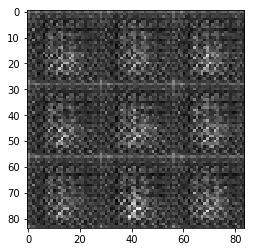

Epoch 1/2... Step: 110... Discriminator Loss: 0.4432... Generator Loss: 1.5754
Epoch 1/2... Step: 120... Discriminator Loss: 1.2236... Generator Loss: 0.7785
Epoch 1/2... Step: 130... Discriminator Loss: 1.1874... Generator Loss: 0.6278
Epoch 1/2... Step: 140... Discriminator Loss: 1.0224... Generator Loss: 0.9559
Epoch 1/2... Step: 150... Discriminator Loss: 1.1795... Generator Loss: 0.5046
Epoch 1/2... Step: 160... Discriminator Loss: 0.7696... Generator Loss: 1.2663
Epoch 1/2... Step: 170... Discriminator Loss: 0.7035... Generator Loss: 1.9306
Epoch 1/2... Step: 180... Discriminator Loss: 1.0122... Generator Loss: 0.8465
Epoch 1/2... Step: 190... Discriminator Loss: 0.9843... Generator Loss: 1.3093
Epoch 1/2... Step: 200... Discriminator Loss: 0.9257... Generator Loss: 1.0017
Cumulative Average Generator Loss / Discriminator Loss: 1.933963656425476
Current Generator Loss / Discriminator Loss: 1.0820112228393555


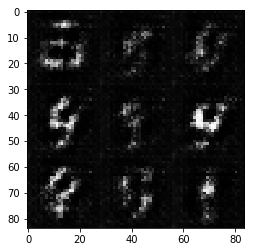

Epoch 1/2... Step: 210... Discriminator Loss: 1.1040... Generator Loss: 2.0808
Epoch 1/2... Step: 220... Discriminator Loss: 1.0604... Generator Loss: 0.7581
Epoch 1/2... Step: 230... Discriminator Loss: 1.0970... Generator Loss: 0.6322
Epoch 1/2... Step: 240... Discriminator Loss: 0.9598... Generator Loss: 0.7441
Epoch 1/2... Step: 250... Discriminator Loss: 0.9179... Generator Loss: 2.4421
Epoch 1/2... Step: 260... Discriminator Loss: 1.3691... Generator Loss: 0.3888
Epoch 1/2... Step: 270... Discriminator Loss: 0.7123... Generator Loss: 1.3496
Epoch 1/2... Step: 280... Discriminator Loss: 1.5003... Generator Loss: 0.3717
Epoch 1/2... Step: 290... Discriminator Loss: 1.0825... Generator Loss: 0.7159
Epoch 1/2... Step: 300... Discriminator Loss: 1.1274... Generator Loss: 0.5506
Cumulative Average Generator Loss / Discriminator Loss: 1.5516785383224487
Current Generator Loss / Discriminator Loss: 0.48836079239845276


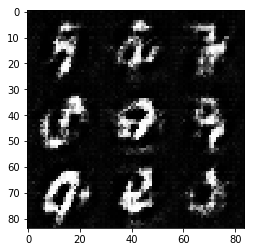

Epoch 1/2... Step: 310... Discriminator Loss: 1.2119... Generator Loss: 0.4618
Epoch 1/2... Step: 320... Discriminator Loss: 1.0863... Generator Loss: 0.5919
Epoch 1/2... Step: 330... Discriminator Loss: 1.0277... Generator Loss: 0.8008
Epoch 1/2... Step: 340... Discriminator Loss: 1.4702... Generator Loss: 2.6425
Epoch 1/2... Step: 350... Discriminator Loss: 0.7248... Generator Loss: 1.1552
Epoch 1/2... Step: 360... Discriminator Loss: 0.7739... Generator Loss: 1.7617
Epoch 1/2... Step: 370... Discriminator Loss: 1.4281... Generator Loss: 0.3585
Epoch 1/2... Step: 380... Discriminator Loss: 0.8685... Generator Loss: 0.7864
Epoch 1/2... Step: 390... Discriminator Loss: 1.1257... Generator Loss: 0.5711
Epoch 1/2... Step: 400... Discriminator Loss: 0.9206... Generator Loss: 0.8812
Cumulative Average Generator Loss / Discriminator Loss: 1.388029932975769
Current Generator Loss / Discriminator Loss: 0.9572595357894897


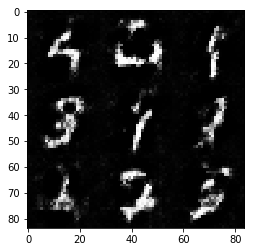

Epoch 1/2... Step: 410... Discriminator Loss: 0.9682... Generator Loss: 0.8747
Epoch 1/2... Step: 420... Discriminator Loss: 0.8786... Generator Loss: 1.1189
Epoch 1/2... Step: 430... Discriminator Loss: 0.7019... Generator Loss: 1.6083
Epoch 1/2... Step: 440... Discriminator Loss: 0.9981... Generator Loss: 0.7165
Epoch 1/2... Step: 450... Discriminator Loss: 0.8817... Generator Loss: 0.8821
Epoch 1/2... Step: 460... Discriminator Loss: 0.8164... Generator Loss: 1.0702
Epoch 1/2... Step: 470... Discriminator Loss: 0.9213... Generator Loss: 0.9069
Epoch 1/2... Step: 480... Discriminator Loss: 1.3555... Generator Loss: 0.3823
Epoch 1/2... Step: 490... Discriminator Loss: 1.0408... Generator Loss: 0.6652
Epoch 1/2... Step: 500... Discriminator Loss: 1.0759... Generator Loss: 0.6984
Cumulative Average Generator Loss / Discriminator Loss: 1.2977142333984375
Current Generator Loss / Discriminator Loss: 0.6491466760635376


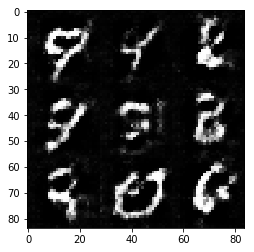

Epoch 1/2... Step: 510... Discriminator Loss: 0.8680... Generator Loss: 0.9949
Epoch 1/2... Step: 520... Discriminator Loss: 1.0031... Generator Loss: 0.7393
Epoch 1/2... Step: 530... Discriminator Loss: 1.2361... Generator Loss: 0.4416
Epoch 1/2... Step: 540... Discriminator Loss: 1.0306... Generator Loss: 1.4280
Epoch 1/2... Step: 550... Discriminator Loss: 0.8664... Generator Loss: 1.2261
Epoch 1/2... Step: 560... Discriminator Loss: 0.9100... Generator Loss: 0.8159
Epoch 1/2... Step: 570... Discriminator Loss: 1.0204... Generator Loss: 2.0594
Epoch 1/2... Step: 580... Discriminator Loss: 0.8647... Generator Loss: 1.0527
Epoch 1/2... Step: 590... Discriminator Loss: 0.8437... Generator Loss: 1.3210
Epoch 1/2... Step: 600... Discriminator Loss: 1.0069... Generator Loss: 1.5608
Cumulative Average Generator Loss / Discriminator Loss: 1.2827367782592773
Current Generator Loss / Discriminator Loss: 1.5501244068145752


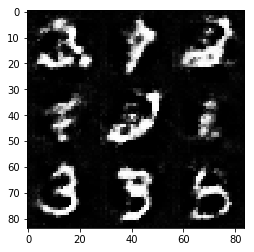

Epoch 1/2... Step: 610... Discriminator Loss: 1.1241... Generator Loss: 0.6275
Epoch 1/2... Step: 620... Discriminator Loss: 0.8145... Generator Loss: 1.2336
Epoch 1/2... Step: 630... Discriminator Loss: 0.8778... Generator Loss: 0.8652
Epoch 1/2... Step: 640... Discriminator Loss: 1.3486... Generator Loss: 0.4023
Epoch 1/2... Step: 650... Discriminator Loss: 0.9173... Generator Loss: 0.8951
Epoch 1/2... Step: 660... Discriminator Loss: 0.8963... Generator Loss: 0.8198
Epoch 1/2... Step: 670... Discriminator Loss: 0.8761... Generator Loss: 0.8813
Epoch 1/2... Step: 680... Discriminator Loss: 1.0814... Generator Loss: 0.5857
Epoch 1/2... Step: 690... Discriminator Loss: 0.8666... Generator Loss: 1.1100
Epoch 1/2... Step: 700... Discriminator Loss: 0.8199... Generator Loss: 1.1258
Cumulative Average Generator Loss / Discriminator Loss: 1.2273893356323242
Current Generator Loss / Discriminator Loss: 1.3731358051300049


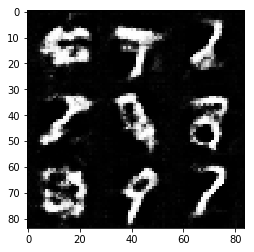

Epoch 1/2... Step: 710... Discriminator Loss: 0.9381... Generator Loss: 1.1919
Epoch 1/2... Step: 720... Discriminator Loss: 0.9985... Generator Loss: 0.7317
Epoch 1/2... Step: 730... Discriminator Loss: 1.0007... Generator Loss: 0.6514
Epoch 1/2... Step: 740... Discriminator Loss: 0.8496... Generator Loss: 1.4593
Epoch 1/2... Step: 750... Discriminator Loss: 0.8366... Generator Loss: 1.1009
Epoch 1/2... Step: 760... Discriminator Loss: 0.6773... Generator Loss: 1.9180
Epoch 1/2... Step: 770... Discriminator Loss: 1.0791... Generator Loss: 0.5861
Epoch 1/2... Step: 780... Discriminator Loss: 0.8595... Generator Loss: 1.1345
Epoch 1/2... Step: 790... Discriminator Loss: 0.8369... Generator Loss: 0.8450
Epoch 1/2... Step: 800... Discriminator Loss: 0.9455... Generator Loss: 0.7211
Cumulative Average Generator Loss / Discriminator Loss: 1.2179391384124756
Current Generator Loss / Discriminator Loss: 0.7626844644546509


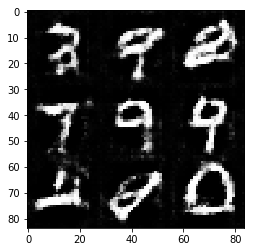

Epoch 1/2... Step: 810... Discriminator Loss: 0.8334... Generator Loss: 1.1774
Epoch 1/2... Step: 820... Discriminator Loss: 1.1449... Generator Loss: 0.5937
Epoch 1/2... Step: 830... Discriminator Loss: 1.0533... Generator Loss: 0.6329
Epoch 1/2... Step: 840... Discriminator Loss: 1.3374... Generator Loss: 0.3710
Epoch 1/2... Step: 850... Discriminator Loss: 0.8269... Generator Loss: 0.8503
Epoch 1/2... Step: 860... Discriminator Loss: 1.0404... Generator Loss: 0.6512
Epoch 1/2... Step: 870... Discriminator Loss: 1.0132... Generator Loss: 0.6387
Epoch 1/2... Step: 880... Discriminator Loss: 0.8264... Generator Loss: 0.9442
Epoch 1/2... Step: 890... Discriminator Loss: 1.4933... Generator Loss: 0.3588
Epoch 1/2... Step: 900... Discriminator Loss: 0.9680... Generator Loss: 0.6802
Cumulative Average Generator Loss / Discriminator Loss: 1.1506141424179077
Current Generator Loss / Discriminator Loss: 0.7026724815368652


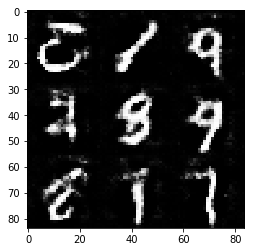

Epoch 1/2... Step: 910... Discriminator Loss: 0.8709... Generator Loss: 0.9300
Epoch 1/2... Step: 920... Discriminator Loss: 0.8102... Generator Loss: 1.5257
Epoch 1/2... Step: 930... Discriminator Loss: 1.1500... Generator Loss: 0.5555
Epoch 2/2... Step: 940... Discriminator Loss: 0.8798... Generator Loss: 1.1549
Epoch 2/2... Step: 950... Discriminator Loss: 1.0283... Generator Loss: 0.7509
Epoch 2/2... Step: 960... Discriminator Loss: 1.2871... Generator Loss: 0.4329
Epoch 2/2... Step: 970... Discriminator Loss: 0.8393... Generator Loss: 1.1492
Epoch 2/2... Step: 980... Discriminator Loss: 1.2944... Generator Loss: 0.4078
Epoch 2/2... Step: 990... Discriminator Loss: 0.9508... Generator Loss: 1.2717
Epoch 2/2... Step: 1000... Discriminator Loss: 0.8710... Generator Loss: 1.4221
Cumulative Average Generator Loss / Discriminator Loss: 1.1314140558242798
Current Generator Loss / Discriminator Loss: 1.6328030824661255


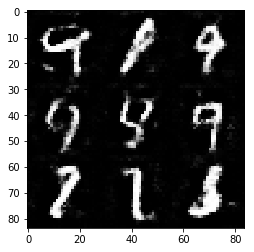

Epoch 2/2... Step: 1010... Discriminator Loss: 1.3880... Generator Loss: 0.3891
Epoch 2/2... Step: 1020... Discriminator Loss: 1.5012... Generator Loss: 0.3447
Epoch 2/2... Step: 1030... Discriminator Loss: 1.4758... Generator Loss: 0.3172
Epoch 2/2... Step: 1040... Discriminator Loss: 0.9674... Generator Loss: 1.2903
Epoch 2/2... Step: 1050... Discriminator Loss: 0.8803... Generator Loss: 0.7823
Epoch 2/2... Step: 1060... Discriminator Loss: 0.7857... Generator Loss: 0.9774
Epoch 2/2... Step: 1070... Discriminator Loss: 0.9850... Generator Loss: 1.3675
Epoch 2/2... Step: 1080... Discriminator Loss: 1.1761... Generator Loss: 0.4673
Epoch 2/2... Step: 1090... Discriminator Loss: 0.8438... Generator Loss: 0.9354
Epoch 2/2... Step: 1100... Discriminator Loss: 0.9132... Generator Loss: 1.0382
Cumulative Average Generator Loss / Discriminator Loss: 1.0906885862350464
Current Generator Loss / Discriminator Loss: 1.1368757486343384


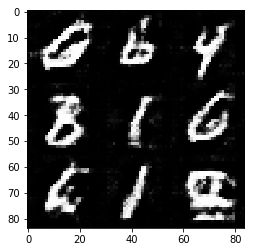

Epoch 2/2... Step: 1110... Discriminator Loss: 1.1465... Generator Loss: 0.5411
Epoch 2/2... Step: 1120... Discriminator Loss: 0.8895... Generator Loss: 2.2381
Epoch 2/2... Step: 1130... Discriminator Loss: 1.0289... Generator Loss: 0.9588
Epoch 2/2... Step: 1140... Discriminator Loss: 0.9879... Generator Loss: 0.9069
Epoch 2/2... Step: 1150... Discriminator Loss: 1.1092... Generator Loss: 0.6470
Epoch 2/2... Step: 1160... Discriminator Loss: 0.8225... Generator Loss: 1.8912
Epoch 2/2... Step: 1170... Discriminator Loss: 1.0572... Generator Loss: 0.6858
Epoch 2/2... Step: 1180... Discriminator Loss: 0.8806... Generator Loss: 0.8750
Epoch 2/2... Step: 1190... Discriminator Loss: 1.6728... Generator Loss: 0.2716
Epoch 2/2... Step: 1200... Discriminator Loss: 1.0831... Generator Loss: 0.8520
Cumulative Average Generator Loss / Discriminator Loss: 1.075830101966858
Current Generator Loss / Discriminator Loss: 0.7866014838218689


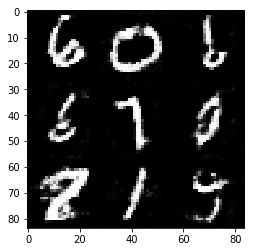

Epoch 2/2... Step: 1210... Discriminator Loss: 1.5049... Generator Loss: 0.3529
Epoch 2/2... Step: 1220... Discriminator Loss: 0.6197... Generator Loss: 1.2327
Epoch 2/2... Step: 1230... Discriminator Loss: 0.8767... Generator Loss: 0.7199
Epoch 2/2... Step: 1240... Discriminator Loss: 0.7242... Generator Loss: 1.1801
Epoch 2/2... Step: 1250... Discriminator Loss: 0.7754... Generator Loss: 2.0949
Epoch 2/2... Step: 1260... Discriminator Loss: 1.3110... Generator Loss: 0.4388
Epoch 2/2... Step: 1270... Discriminator Loss: 1.0007... Generator Loss: 0.7082
Epoch 2/2... Step: 1280... Discriminator Loss: 0.9788... Generator Loss: 0.6332
Epoch 2/2... Step: 1290... Discriminator Loss: 0.9629... Generator Loss: 0.7505
Epoch 2/2... Step: 1300... Discriminator Loss: 1.4282... Generator Loss: 0.3646
Cumulative Average Generator Loss / Discriminator Loss: 1.0567514896392822
Current Generator Loss / Discriminator Loss: 0.25532063841819763


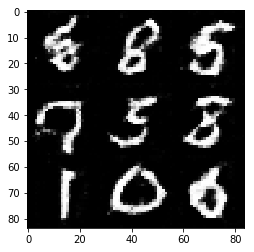

Epoch 2/2... Step: 1310... Discriminator Loss: 1.4748... Generator Loss: 0.3555
Epoch 2/2... Step: 1320... Discriminator Loss: 0.8559... Generator Loss: 0.7914
Epoch 2/2... Step: 1330... Discriminator Loss: 0.8131... Generator Loss: 1.0712
Epoch 2/2... Step: 1340... Discriminator Loss: 1.0547... Generator Loss: 0.6458
Epoch 2/2... Step: 1350... Discriminator Loss: 1.2336... Generator Loss: 0.4456
Epoch 2/2... Step: 1360... Discriminator Loss: 1.0317... Generator Loss: 0.5976
Epoch 2/2... Step: 1370... Discriminator Loss: 1.8299... Generator Loss: 0.2186
Epoch 2/2... Step: 1380... Discriminator Loss: 0.9297... Generator Loss: 1.6887
Epoch 2/2... Step: 1390... Discriminator Loss: 0.8015... Generator Loss: 0.8809
Epoch 2/2... Step: 1400... Discriminator Loss: 0.9971... Generator Loss: 0.6370
Cumulative Average Generator Loss / Discriminator Loss: 1.0261355638504028
Current Generator Loss / Discriminator Loss: 0.6389181613922119


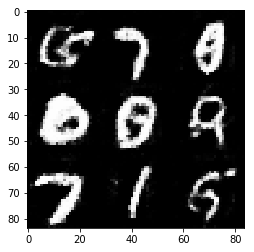

Epoch 2/2... Step: 1410... Discriminator Loss: 0.7915... Generator Loss: 1.0613
Epoch 2/2... Step: 1420... Discriminator Loss: 1.2840... Generator Loss: 0.4460
Epoch 2/2... Step: 1430... Discriminator Loss: 0.8252... Generator Loss: 0.9754
Epoch 2/2... Step: 1440... Discriminator Loss: 1.2161... Generator Loss: 0.4980
Epoch 2/2... Step: 1450... Discriminator Loss: 1.1418... Generator Loss: 0.5660
Epoch 2/2... Step: 1460... Discriminator Loss: 1.7810... Generator Loss: 0.2249
Epoch 2/2... Step: 1470... Discriminator Loss: 0.6540... Generator Loss: 1.4588
Epoch 2/2... Step: 1480... Discriminator Loss: 1.5384... Generator Loss: 0.3131
Epoch 2/2... Step: 1490... Discriminator Loss: 0.7353... Generator Loss: 1.3213
Epoch 2/2... Step: 1500... Discriminator Loss: 1.1237... Generator Loss: 0.5362
Cumulative Average Generator Loss / Discriminator Loss: 0.9999597668647766
Current Generator Loss / Discriminator Loss: 0.4771588444709778


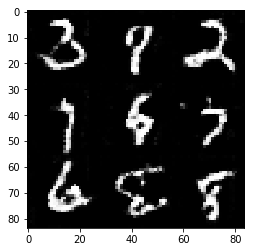

Epoch 2/2... Step: 1510... Discriminator Loss: 0.9397... Generator Loss: 0.8201
Epoch 2/2... Step: 1520... Discriminator Loss: 1.0658... Generator Loss: 0.6908
Epoch 2/2... Step: 1530... Discriminator Loss: 0.7695... Generator Loss: 1.4126
Epoch 2/2... Step: 1540... Discriminator Loss: 0.7653... Generator Loss: 1.5752
Epoch 2/2... Step: 1550... Discriminator Loss: 0.9681... Generator Loss: 0.7353
Epoch 2/2... Step: 1560... Discriminator Loss: 0.5915... Generator Loss: 1.4668
Epoch 2/2... Step: 1570... Discriminator Loss: 0.9767... Generator Loss: 0.7110
Epoch 2/2... Step: 1580... Discriminator Loss: 1.3965... Generator Loss: 0.3768
Epoch 2/2... Step: 1590... Discriminator Loss: 1.1099... Generator Loss: 0.6423
Epoch 2/2... Step: 1600... Discriminator Loss: 1.1955... Generator Loss: 0.5414
Cumulative Average Generator Loss / Discriminator Loss: 0.9949794411659241
Current Generator Loss / Discriminator Loss: 0.45286595821380615


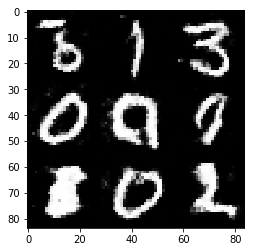

Epoch 2/2... Step: 1610... Discriminator Loss: 1.0162... Generator Loss: 2.4122
Epoch 2/2... Step: 1620... Discriminator Loss: 1.2310... Generator Loss: 0.4727
Epoch 2/2... Step: 1630... Discriminator Loss: 1.2444... Generator Loss: 0.4827
Epoch 2/2... Step: 1640... Discriminator Loss: 1.0370... Generator Loss: 0.6432
Epoch 2/2... Step: 1650... Discriminator Loss: 0.7714... Generator Loss: 1.2499
Epoch 2/2... Step: 1660... Discriminator Loss: 1.4880... Generator Loss: 0.3379
Epoch 2/2... Step: 1670... Discriminator Loss: 1.0264... Generator Loss: 0.5950
Epoch 2/2... Step: 1680... Discriminator Loss: 1.7045... Generator Loss: 0.2598
Epoch 2/2... Step: 1690... Discriminator Loss: 0.8780... Generator Loss: 0.9904
Epoch 2/2... Step: 1700... Discriminator Loss: 1.4812... Generator Loss: 0.3417
Cumulative Average Generator Loss / Discriminator Loss: 0.971759557723999
Current Generator Loss / Discriminator Loss: 0.23071527481079102


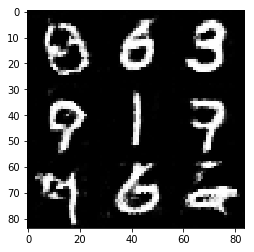

Epoch 2/2... Step: 1710... Discriminator Loss: 0.7015... Generator Loss: 1.0939
Epoch 2/2... Step: 1720... Discriminator Loss: 0.7933... Generator Loss: 0.8954
Epoch 2/2... Step: 1730... Discriminator Loss: 1.3264... Generator Loss: 0.4002
Epoch 2/2... Step: 1740... Discriminator Loss: 1.2599... Generator Loss: 0.4543
Epoch 2/2... Step: 1750... Discriminator Loss: 0.8720... Generator Loss: 1.0339
Epoch 2/2... Step: 1760... Discriminator Loss: 0.6127... Generator Loss: 1.1268
Epoch 2/2... Step: 1770... Discriminator Loss: 1.1929... Generator Loss: 0.5817
Epoch 2/2... Step: 1780... Discriminator Loss: 1.2242... Generator Loss: 0.4881
Epoch 2/2... Step: 1790... Discriminator Loss: 0.8122... Generator Loss: 1.7979
Epoch 2/2... Step: 1800... Discriminator Loss: 1.3207... Generator Loss: 0.4070
Cumulative Average Generator Loss / Discriminator Loss: 0.9633219838142395
Current Generator Loss / Discriminator Loss: 0.3081885576248169


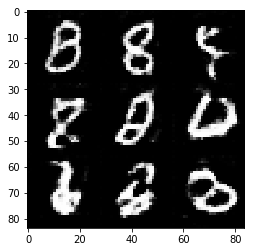

Epoch 2/2... Step: 1810... Discriminator Loss: 0.6688... Generator Loss: 1.2898
Epoch 2/2... Step: 1820... Discriminator Loss: 1.6161... Generator Loss: 0.2790
Epoch 2/2... Step: 1830... Discriminator Loss: 1.1808... Generator Loss: 0.5479
Epoch 2/2... Step: 1840... Discriminator Loss: 1.3512... Generator Loss: 0.4018
Epoch 2/2... Step: 1850... Discriminator Loss: 0.6836... Generator Loss: 1.1165
Epoch 2/2... Step: 1860... Discriminator Loss: 1.8292... Generator Loss: 0.2208
Epoch 2/2... Step: 1870... Discriminator Loss: 0.7168... Generator Loss: 0.9602


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step: 10... Discriminator Loss: 0.5340... Generator Loss: 1.2133
Epoch 1/1... Step: 20... Discriminator Loss: 0.6448... Generator Loss: 1.0293
Epoch 1/1... Step: 30... Discriminator Loss: 0.1296... Generator Loss: 5.0341
Epoch 1/1... Step: 40... Discriminator Loss: 0.1240... Generator Loss: 6.3478
Epoch 1/1... Step: 50... Discriminator Loss: 0.0826... Generator Loss: 4.0656
Epoch 1/1... Step: 60... Discriminator Loss: 0.2625... Generator Loss: 2.0560
Epoch 1/1... Step: 70... Discriminator Loss: 0.7539... Generator Loss: 1.0164
Epoch 1/1... Step: 80... Discriminator Loss: 0.8431... Generator Loss: 0.7136
Epoch 1/1... Step: 90... Discriminator Loss: 0.7381... Generator Loss: 1.6414
Epoch 1/1... Step: 100... Discriminator Loss: 0.9978... Generator Loss: 0.6287
Cumulative Average Generator Loss / Discriminator Loss: 4.646576881408691
Current Generator Loss / Discriminator Loss: 0.6300402283668518


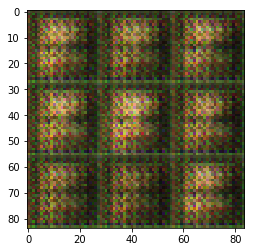

Epoch 1/1... Step: 110... Discriminator Loss: 1.0813... Generator Loss: 0.8266
Epoch 1/1... Step: 120... Discriminator Loss: 0.2362... Generator Loss: 2.6634
Epoch 1/1... Step: 130... Discriminator Loss: 0.9237... Generator Loss: 0.8750
Epoch 1/1... Step: 140... Discriminator Loss: 0.5090... Generator Loss: 2.4634
Epoch 1/1... Step: 150... Discriminator Loss: 1.4173... Generator Loss: 0.3594
Epoch 1/1... Step: 160... Discriminator Loss: 0.6562... Generator Loss: 1.8722
Epoch 1/1... Step: 170... Discriminator Loss: 1.4315... Generator Loss: 0.4211
Epoch 1/1... Step: 180... Discriminator Loss: 0.7072... Generator Loss: 1.0730
Epoch 1/1... Step: 190... Discriminator Loss: 0.9551... Generator Loss: 0.7716
Epoch 1/1... Step: 200... Discriminator Loss: 0.8283... Generator Loss: 1.4061
Cumulative Average Generator Loss / Discriminator Loss: 2.6325862407684326
Current Generator Loss / Discriminator Loss: 1.6975209712982178


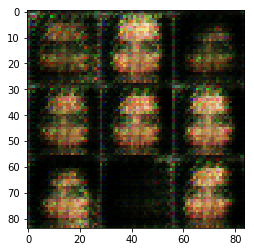

Epoch 1/1... Step: 210... Discriminator Loss: 0.8150... Generator Loss: 1.0632
Epoch 1/1... Step: 220... Discriminator Loss: 1.0891... Generator Loss: 0.6756
Epoch 1/1... Step: 230... Discriminator Loss: 1.4837... Generator Loss: 3.3998
Epoch 1/1... Step: 240... Discriminator Loss: 0.8483... Generator Loss: 0.8086
Epoch 1/1... Step: 250... Discriminator Loss: 0.7394... Generator Loss: 1.4479
Epoch 1/1... Step: 260... Discriminator Loss: 0.6185... Generator Loss: 1.8115
Epoch 1/1... Step: 270... Discriminator Loss: 0.6258... Generator Loss: 1.4591
Epoch 1/1... Step: 280... Discriminator Loss: 0.6971... Generator Loss: 1.0517
Epoch 1/1... Step: 290... Discriminator Loss: 0.6756... Generator Loss: 1.4520
Epoch 1/1... Step: 300... Discriminator Loss: 0.7583... Generator Loss: 1.6820
Cumulative Average Generator Loss / Discriminator Loss: 2.311399221420288
Current Generator Loss / Discriminator Loss: 2.2181174755096436


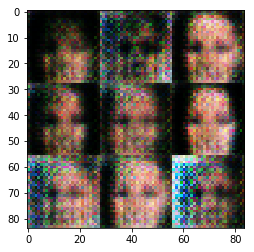

Epoch 1/1... Step: 310... Discriminator Loss: 0.9938... Generator Loss: 0.8782
Epoch 1/1... Step: 320... Discriminator Loss: 0.6882... Generator Loss: 1.4889
Epoch 1/1... Step: 330... Discriminator Loss: 1.3820... Generator Loss: 3.4851
Epoch 1/1... Step: 340... Discriminator Loss: 0.9410... Generator Loss: 0.8290
Epoch 1/1... Step: 350... Discriminator Loss: 0.6804... Generator Loss: 1.2766
Epoch 1/1... Step: 360... Discriminator Loss: 1.1781... Generator Loss: 0.6296
Epoch 1/1... Step: 370... Discriminator Loss: 0.7390... Generator Loss: 1.7156
Epoch 1/1... Step: 380... Discriminator Loss: 1.0468... Generator Loss: 0.6866
Epoch 1/1... Step: 390... Discriminator Loss: 0.6545... Generator Loss: 1.6964
Epoch 1/1... Step: 400... Discriminator Loss: 0.9648... Generator Loss: 0.8907
Cumulative Average Generator Loss / Discriminator Loss: 2.0621097087860107
Current Generator Loss / Discriminator Loss: 0.9231415390968323


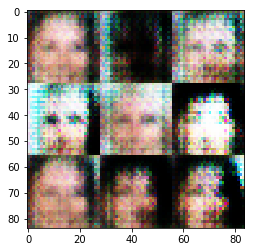

Epoch 1/1... Step: 410... Discriminator Loss: 0.7702... Generator Loss: 1.2959
Epoch 1/1... Step: 420... Discriminator Loss: 0.8380... Generator Loss: 1.2200
Epoch 1/1... Step: 430... Discriminator Loss: 0.8612... Generator Loss: 1.0055
Epoch 1/1... Step: 440... Discriminator Loss: 0.7111... Generator Loss: 1.7606
Epoch 1/1... Step: 450... Discriminator Loss: 0.7634... Generator Loss: 1.3446
Epoch 1/1... Step: 460... Discriminator Loss: 0.5784... Generator Loss: 1.5993
Epoch 1/1... Step: 470... Discriminator Loss: 0.8152... Generator Loss: 0.8041
Epoch 1/1... Step: 480... Discriminator Loss: 0.6175... Generator Loss: 1.3248
Epoch 1/1... Step: 490... Discriminator Loss: 0.7761... Generator Loss: 1.2830
Epoch 1/1... Step: 500... Discriminator Loss: 0.7044... Generator Loss: 1.9247
Cumulative Average Generator Loss / Discriminator Loss: 2.0166189670562744
Current Generator Loss / Discriminator Loss: 2.732599973678589


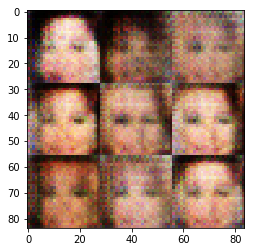

Epoch 1/1... Step: 510... Discriminator Loss: 0.9755... Generator Loss: 1.6608
Epoch 1/1... Step: 520... Discriminator Loss: 1.1898... Generator Loss: 1.4107
Epoch 1/1... Step: 530... Discriminator Loss: 0.7579... Generator Loss: 1.1120
Epoch 1/1... Step: 540... Discriminator Loss: 0.9763... Generator Loss: 0.8933
Epoch 1/1... Step: 550... Discriminator Loss: 1.1849... Generator Loss: 0.6629
Epoch 1/1... Step: 560... Discriminator Loss: 0.9409... Generator Loss: 0.9669
Epoch 1/1... Step: 570... Discriminator Loss: 0.8466... Generator Loss: 0.9263
Epoch 1/1... Step: 580... Discriminator Loss: 0.7435... Generator Loss: 1.3587
Epoch 1/1... Step: 590... Discriminator Loss: 0.8075... Generator Loss: 1.6426
Epoch 1/1... Step: 600... Discriminator Loss: 1.0568... Generator Loss: 1.2845
Cumulative Average Generator Loss / Discriminator Loss: 1.8678723573684692
Current Generator Loss / Discriminator Loss: 1.215428352355957


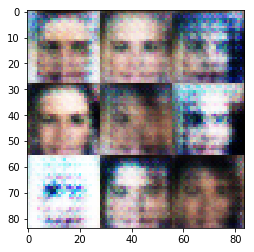

Epoch 1/1... Step: 610... Discriminator Loss: 1.3250... Generator Loss: 0.6456
Epoch 1/1... Step: 620... Discriminator Loss: 0.9009... Generator Loss: 1.0893
Epoch 1/1... Step: 630... Discriminator Loss: 0.9084... Generator Loss: 0.8107
Epoch 1/1... Step: 640... Discriminator Loss: 1.0784... Generator Loss: 1.4505
Epoch 1/1... Step: 650... Discriminator Loss: 1.6631... Generator Loss: 0.3294
Epoch 1/1... Step: 660... Discriminator Loss: 0.9786... Generator Loss: 1.2161
Epoch 1/1... Step: 670... Discriminator Loss: 1.5656... Generator Loss: 0.4216
Epoch 1/1... Step: 680... Discriminator Loss: 1.2417... Generator Loss: 0.7624
Epoch 1/1... Step: 690... Discriminator Loss: 1.0001... Generator Loss: 1.1085
Epoch 1/1... Step: 700... Discriminator Loss: 0.7479... Generator Loss: 1.0447
Cumulative Average Generator Loss / Discriminator Loss: 1.659958839416504
Current Generator Loss / Discriminator Loss: 1.396843671798706


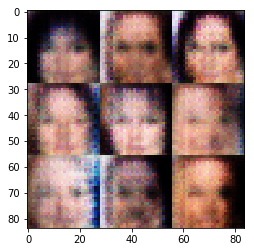

Epoch 1/1... Step: 710... Discriminator Loss: 0.8332... Generator Loss: 1.0578
Epoch 1/1... Step: 720... Discriminator Loss: 0.9529... Generator Loss: 1.4496
Epoch 1/1... Step: 730... Discriminator Loss: 1.5977... Generator Loss: 2.2829
Epoch 1/1... Step: 740... Discriminator Loss: 1.1586... Generator Loss: 0.5623
Epoch 1/1... Step: 750... Discriminator Loss: 0.8706... Generator Loss: 1.2314
Epoch 1/1... Step: 760... Discriminator Loss: 0.8091... Generator Loss: 1.0501
Epoch 1/1... Step: 770... Discriminator Loss: 0.9906... Generator Loss: 1.1978
Epoch 1/1... Step: 780... Discriminator Loss: 0.8164... Generator Loss: 1.0847
Epoch 1/1... Step: 790... Discriminator Loss: 1.3130... Generator Loss: 0.5309
Epoch 1/1... Step: 800... Discriminator Loss: 1.0128... Generator Loss: 1.0046
Cumulative Average Generator Loss / Discriminator Loss: 1.5781875848770142
Current Generator Loss / Discriminator Loss: 0.9918616414070129


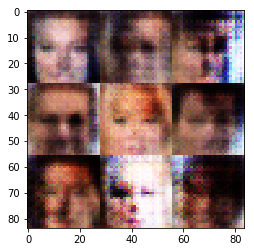

Epoch 1/1... Step: 810... Discriminator Loss: 1.1819... Generator Loss: 0.6361
Epoch 1/1... Step: 820... Discriminator Loss: 0.9451... Generator Loss: 0.8218
Epoch 1/1... Step: 830... Discriminator Loss: 0.9121... Generator Loss: 1.3878
Epoch 1/1... Step: 840... Discriminator Loss: 0.9759... Generator Loss: 0.8547
Epoch 1/1... Step: 850... Discriminator Loss: 1.1595... Generator Loss: 0.6262
Epoch 1/1... Step: 860... Discriminator Loss: 0.6803... Generator Loss: 1.2031
Epoch 1/1... Step: 870... Discriminator Loss: 0.8963... Generator Loss: 1.3229
Epoch 1/1... Step: 880... Discriminator Loss: 0.7693... Generator Loss: 1.1891
Epoch 1/1... Step: 890... Discriminator Loss: 0.8205... Generator Loss: 0.9261
Epoch 1/1... Step: 900... Discriminator Loss: 0.8655... Generator Loss: 1.0205
Cumulative Average Generator Loss / Discriminator Loss: 1.5209674835205078
Current Generator Loss / Discriminator Loss: 1.1791070699691772


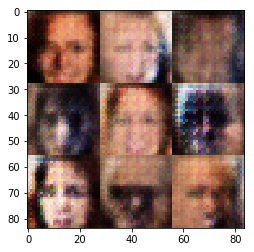

Epoch 1/1... Step: 910... Discriminator Loss: 1.0025... Generator Loss: 0.6660
Epoch 1/1... Step: 920... Discriminator Loss: 0.8093... Generator Loss: 0.9968
Epoch 1/1... Step: 930... Discriminator Loss: 0.9544... Generator Loss: 1.2213
Epoch 1/1... Step: 940... Discriminator Loss: 0.8655... Generator Loss: 1.0014
Epoch 1/1... Step: 950... Discriminator Loss: 0.9668... Generator Loss: 0.7953
Epoch 1/1... Step: 960... Discriminator Loss: 1.1121... Generator Loss: 0.6725
Epoch 1/1... Step: 970... Discriminator Loss: 0.8278... Generator Loss: 1.1451
Epoch 1/1... Step: 980... Discriminator Loss: 0.9932... Generator Loss: 1.0709
Epoch 1/1... Step: 990... Discriminator Loss: 1.0052... Generator Loss: 0.7244
Epoch 1/1... Step: 1000... Discriminator Loss: 0.9532... Generator Loss: 0.9378
Cumulative Average Generator Loss / Discriminator Loss: 1.462412714958191
Current Generator Loss / Discriminator Loss: 0.9838225841522217


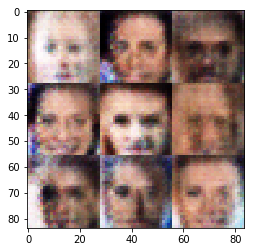

Epoch 1/1... Step: 1010... Discriminator Loss: 0.8778... Generator Loss: 0.9949
Epoch 1/1... Step: 1020... Discriminator Loss: 0.6987... Generator Loss: 1.1741
Epoch 1/1... Step: 1030... Discriminator Loss: 1.1600... Generator Loss: 0.5428
Epoch 1/1... Step: 1040... Discriminator Loss: 0.6507... Generator Loss: 1.2829
Epoch 1/1... Step: 1050... Discriminator Loss: 0.8149... Generator Loss: 0.9784
Epoch 1/1... Step: 1060... Discriminator Loss: 0.9540... Generator Loss: 1.0110
Epoch 1/1... Step: 1070... Discriminator Loss: 0.9103... Generator Loss: 0.9890
Epoch 1/1... Step: 1080... Discriminator Loss: 0.9413... Generator Loss: 0.7518
Epoch 1/1... Step: 1090... Discriminator Loss: 0.8811... Generator Loss: 1.0585
Epoch 1/1... Step: 1100... Discriminator Loss: 1.0755... Generator Loss: 1.4383
Cumulative Average Generator Loss / Discriminator Loss: 1.4328874349594116
Current Generator Loss / Discriminator Loss: 1.3372441530227661


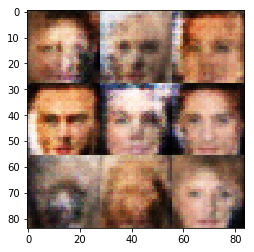

Epoch 1/1... Step: 1110... Discriminator Loss: 0.9168... Generator Loss: 1.0088
Epoch 1/1... Step: 1120... Discriminator Loss: 1.1199... Generator Loss: 0.5893
Epoch 1/1... Step: 1130... Discriminator Loss: 1.1695... Generator Loss: 1.6676
Epoch 1/1... Step: 1140... Discriminator Loss: 0.9838... Generator Loss: 1.0760
Epoch 1/1... Step: 1150... Discriminator Loss: 1.0917... Generator Loss: 0.7967
Epoch 1/1... Step: 1160... Discriminator Loss: 1.0521... Generator Loss: 1.1902
Epoch 1/1... Step: 1170... Discriminator Loss: 0.8881... Generator Loss: 1.1692
Epoch 1/1... Step: 1180... Discriminator Loss: 0.9187... Generator Loss: 1.0303
Epoch 1/1... Step: 1190... Discriminator Loss: 0.8857... Generator Loss: 0.8788
Epoch 1/1... Step: 1200... Discriminator Loss: 1.0404... Generator Loss: 0.8099
Cumulative Average Generator Loss / Discriminator Loss: 1.3938846588134766
Current Generator Loss / Discriminator Loss: 0.7784430980682373


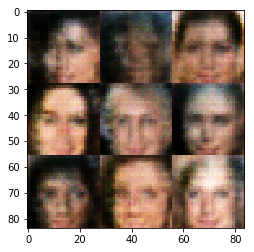

Epoch 1/1... Step: 1210... Discriminator Loss: 1.2793... Generator Loss: 0.4997
Epoch 1/1... Step: 1220... Discriminator Loss: 0.7841... Generator Loss: 1.5483
Epoch 1/1... Step: 1230... Discriminator Loss: 0.9646... Generator Loss: 1.4727
Epoch 1/1... Step: 1240... Discriminator Loss: 0.8259... Generator Loss: 1.7568
Epoch 1/1... Step: 1250... Discriminator Loss: 0.9893... Generator Loss: 1.3562
Epoch 1/1... Step: 1260... Discriminator Loss: 0.8978... Generator Loss: 1.0095
Epoch 1/1... Step: 1270... Discriminator Loss: 1.0955... Generator Loss: 0.6973
Epoch 1/1... Step: 1280... Discriminator Loss: 1.0546... Generator Loss: 0.8081
Epoch 1/1... Step: 1290... Discriminator Loss: 0.8799... Generator Loss: 0.9212
Epoch 1/1... Step: 1300... Discriminator Loss: 1.3165... Generator Loss: 0.5189
Cumulative Average Generator Loss / Discriminator Loss: 1.364452600479126
Current Generator Loss / Discriminator Loss: 0.3941551148891449


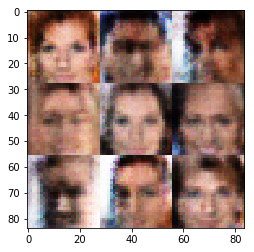

Epoch 1/1... Step: 1310... Discriminator Loss: 1.0046... Generator Loss: 0.8590
Epoch 1/1... Step: 1320... Discriminator Loss: 0.8078... Generator Loss: 1.1292
Epoch 1/1... Step: 1330... Discriminator Loss: 0.9142... Generator Loss: 0.9037
Epoch 1/1... Step: 1340... Discriminator Loss: 0.9732... Generator Loss: 0.9944
Epoch 1/1... Step: 1350... Discriminator Loss: 1.2284... Generator Loss: 0.6962
Epoch 1/1... Step: 1360... Discriminator Loss: 1.1382... Generator Loss: 0.7248
Epoch 1/1... Step: 1370... Discriminator Loss: 0.9101... Generator Loss: 1.0934
Epoch 1/1... Step: 1380... Discriminator Loss: 0.7594... Generator Loss: 1.0471
Epoch 1/1... Step: 1390... Discriminator Loss: 1.2649... Generator Loss: 0.6952
Epoch 1/1... Step: 1400... Discriminator Loss: 0.7834... Generator Loss: 1.1264
Cumulative Average Generator Loss / Discriminator Loss: 1.3325120210647583
Current Generator Loss / Discriminator Loss: 1.4377939701080322


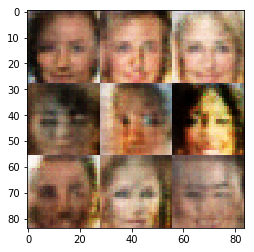

Epoch 1/1... Step: 1410... Discriminator Loss: 0.9269... Generator Loss: 1.5434
Epoch 1/1... Step: 1420... Discriminator Loss: 1.0022... Generator Loss: 0.8963
Epoch 1/1... Step: 1430... Discriminator Loss: 1.0476... Generator Loss: 0.6519
Epoch 1/1... Step: 1440... Discriminator Loss: 0.8151... Generator Loss: 1.0048
Epoch 1/1... Step: 1450... Discriminator Loss: 1.1479... Generator Loss: 0.7059
Epoch 1/1... Step: 1460... Discriminator Loss: 0.9953... Generator Loss: 0.8537
Epoch 1/1... Step: 1470... Discriminator Loss: 1.1540... Generator Loss: 0.7609
Epoch 1/1... Step: 1480... Discriminator Loss: 0.9717... Generator Loss: 1.2396
Epoch 1/1... Step: 1490... Discriminator Loss: 0.8786... Generator Loss: 0.9881
Epoch 1/1... Step: 1500... Discriminator Loss: 1.1673... Generator Loss: 2.7227
Cumulative Average Generator Loss / Discriminator Loss: 1.3172792196273804
Current Generator Loss / Discriminator Loss: 2.3325672149658203


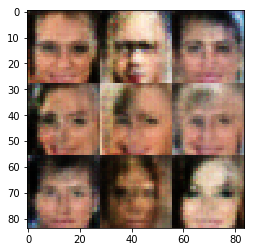

Epoch 1/1... Step: 1510... Discriminator Loss: 0.9847... Generator Loss: 1.0187
Epoch 1/1... Step: 1520... Discriminator Loss: 0.8416... Generator Loss: 1.2683
Epoch 1/1... Step: 1530... Discriminator Loss: 0.8368... Generator Loss: 1.1910
Epoch 1/1... Step: 1540... Discriminator Loss: 1.2796... Generator Loss: 0.5401
Epoch 1/1... Step: 1550... Discriminator Loss: 0.9290... Generator Loss: 0.8671
Epoch 1/1... Step: 1560... Discriminator Loss: 0.8402... Generator Loss: 1.0344
Epoch 1/1... Step: 1570... Discriminator Loss: 1.0062... Generator Loss: 1.3394
Epoch 1/1... Step: 1580... Discriminator Loss: 1.1492... Generator Loss: 1.2342
Epoch 1/1... Step: 1590... Discriminator Loss: 0.7866... Generator Loss: 1.0411
Epoch 1/1... Step: 1600... Discriminator Loss: 0.9180... Generator Loss: 1.2009
Cumulative Average Generator Loss / Discriminator Loss: 1.304570198059082
Current Generator Loss / Discriminator Loss: 1.3082555532455444


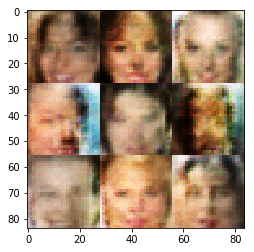

Epoch 1/1... Step: 1610... Discriminator Loss: 0.9428... Generator Loss: 0.9896
Epoch 1/1... Step: 1620... Discriminator Loss: 0.8998... Generator Loss: 0.9793
Epoch 1/1... Step: 1630... Discriminator Loss: 0.9522... Generator Loss: 0.9446
Epoch 1/1... Step: 1640... Discriminator Loss: 0.9374... Generator Loss: 0.9944
Epoch 1/1... Step: 1650... Discriminator Loss: 0.9984... Generator Loss: 0.8024
Epoch 1/1... Step: 1660... Discriminator Loss: 1.0498... Generator Loss: 0.8053
Epoch 1/1... Step: 1670... Discriminator Loss: 1.0665... Generator Loss: 1.2197
Epoch 1/1... Step: 1680... Discriminator Loss: 1.0321... Generator Loss: 1.6091
Epoch 1/1... Step: 1690... Discriminator Loss: 0.8293... Generator Loss: 1.2717
Epoch 1/1... Step: 1700... Discriminator Loss: 1.3562... Generator Loss: 0.4876
Cumulative Average Generator Loss / Discriminator Loss: 1.2853542566299438
Current Generator Loss / Discriminator Loss: 0.3594931960105896


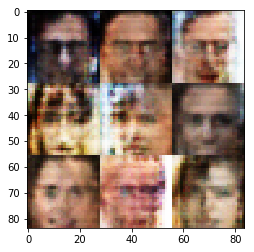

Epoch 1/1... Step: 1710... Discriminator Loss: 0.9454... Generator Loss: 0.8208
Epoch 1/1... Step: 1720... Discriminator Loss: 1.0924... Generator Loss: 0.9088
Epoch 1/1... Step: 1730... Discriminator Loss: 1.0221... Generator Loss: 0.8499
Epoch 1/1... Step: 1740... Discriminator Loss: 0.9330... Generator Loss: 1.2515
Epoch 1/1... Step: 1750... Discriminator Loss: 1.1630... Generator Loss: 0.5918
Epoch 1/1... Step: 1760... Discriminator Loss: 1.0442... Generator Loss: 0.7947
Epoch 1/1... Step: 1770... Discriminator Loss: 1.0711... Generator Loss: 0.7008
Epoch 1/1... Step: 1780... Discriminator Loss: 0.8612... Generator Loss: 1.4672
Epoch 1/1... Step: 1790... Discriminator Loss: 1.0265... Generator Loss: 0.7259
Epoch 1/1... Step: 1800... Discriminator Loss: 0.9796... Generator Loss: 0.8096
Cumulative Average Generator Loss / Discriminator Loss: 1.2608329057693481
Current Generator Loss / Discriminator Loss: 0.8265054821968079


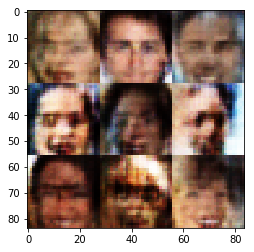

Epoch 1/1... Step: 1810... Discriminator Loss: 1.0947... Generator Loss: 0.6527
Epoch 1/1... Step: 1820... Discriminator Loss: 1.1996... Generator Loss: 0.5510
Epoch 1/1... Step: 1830... Discriminator Loss: 0.9499... Generator Loss: 0.9264
Epoch 1/1... Step: 1840... Discriminator Loss: 1.0479... Generator Loss: 0.7268
Epoch 1/1... Step: 1850... Discriminator Loss: 1.0599... Generator Loss: 0.8525
Epoch 1/1... Step: 1860... Discriminator Loss: 1.0111... Generator Loss: 0.7864
Epoch 1/1... Step: 1870... Discriminator Loss: 1.2260... Generator Loss: 0.4787
Epoch 1/1... Step: 1880... Discriminator Loss: 0.8710... Generator Loss: 1.1315
Epoch 1/1... Step: 1890... Discriminator Loss: 1.2223... Generator Loss: 0.5178
Epoch 1/1... Step: 1900... Discriminator Loss: 1.1331... Generator Loss: 0.8366
Cumulative Average Generator Loss / Discriminator Loss: 1.2262238264083862
Current Generator Loss / Discriminator Loss: 0.738336443901062


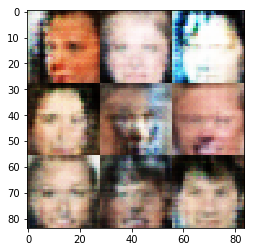

Epoch 1/1... Step: 1910... Discriminator Loss: 1.2878... Generator Loss: 0.5215
Epoch 1/1... Step: 1920... Discriminator Loss: 0.8081... Generator Loss: 0.9748
Epoch 1/1... Step: 1930... Discriminator Loss: 0.8487... Generator Loss: 1.2130
Epoch 1/1... Step: 1940... Discriminator Loss: 1.0029... Generator Loss: 0.7180
Epoch 1/1... Step: 1950... Discriminator Loss: 1.0649... Generator Loss: 0.6834
Epoch 1/1... Step: 1960... Discriminator Loss: 0.8373... Generator Loss: 1.0927
Epoch 1/1... Step: 1970... Discriminator Loss: 0.9705... Generator Loss: 0.8800
Epoch 1/1... Step: 1980... Discriminator Loss: 0.7895... Generator Loss: 1.3645
Epoch 1/1... Step: 1990... Discriminator Loss: 1.1321... Generator Loss: 0.8058
Epoch 1/1... Step: 2000... Discriminator Loss: 0.9588... Generator Loss: 0.8974
Cumulative Average Generator Loss / Discriminator Loss: 1.2116388082504272
Current Generator Loss / Discriminator Loss: 0.9359557628631592


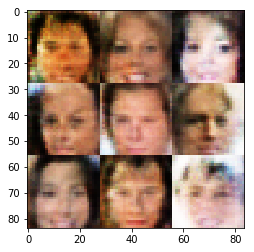

Epoch 1/1... Step: 2010... Discriminator Loss: 0.8661... Generator Loss: 1.0412
Epoch 1/1... Step: 2020... Discriminator Loss: 1.0012... Generator Loss: 0.7203
Epoch 1/1... Step: 2030... Discriminator Loss: 0.8685... Generator Loss: 1.1568
Epoch 1/1... Step: 2040... Discriminator Loss: 0.9563... Generator Loss: 1.4446
Epoch 1/1... Step: 2050... Discriminator Loss: 0.7550... Generator Loss: 1.0612
Epoch 1/1... Step: 2060... Discriminator Loss: 0.9461... Generator Loss: 0.8454
Epoch 1/1... Step: 2070... Discriminator Loss: 1.2492... Generator Loss: 0.5586
Epoch 1/1... Step: 2080... Discriminator Loss: 1.3059... Generator Loss: 0.5039
Epoch 1/1... Step: 2090... Discriminator Loss: 0.9794... Generator Loss: 1.0038
Epoch 1/1... Step: 2100... Discriminator Loss: 0.7411... Generator Loss: 1.4665
Cumulative Average Generator Loss / Discriminator Loss: 1.2019708156585693
Current Generator Loss / Discriminator Loss: 1.9787211418151855


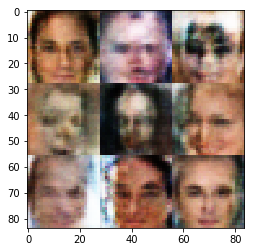

Epoch 1/1... Step: 2110... Discriminator Loss: 0.9907... Generator Loss: 0.8628
Epoch 1/1... Step: 2120... Discriminator Loss: 0.9772... Generator Loss: 0.9318
Epoch 1/1... Step: 2130... Discriminator Loss: 1.3451... Generator Loss: 0.4149
Epoch 1/1... Step: 2140... Discriminator Loss: 0.9873... Generator Loss: 0.7075
Epoch 1/1... Step: 2150... Discriminator Loss: 0.9745... Generator Loss: 0.9649
Epoch 1/1... Step: 2160... Discriminator Loss: 1.3608... Generator Loss: 0.4138
Epoch 1/1... Step: 2170... Discriminator Loss: 1.0305... Generator Loss: 0.8943
Epoch 1/1... Step: 2180... Discriminator Loss: 1.1059... Generator Loss: 1.2769
Epoch 1/1... Step: 2190... Discriminator Loss: 0.9089... Generator Loss: 1.4160
Epoch 1/1... Step: 2200... Discriminator Loss: 0.9393... Generator Loss: 0.7904
Cumulative Average Generator Loss / Discriminator Loss: 1.1823406219482422
Current Generator Loss / Discriminator Loss: 0.8415442705154419


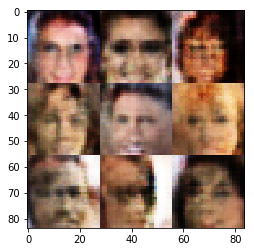

Epoch 1/1... Step: 2210... Discriminator Loss: 1.0318... Generator Loss: 1.0354
Epoch 1/1... Step: 2220... Discriminator Loss: 1.1484... Generator Loss: 0.7910
Epoch 1/1... Step: 2230... Discriminator Loss: 0.9579... Generator Loss: 0.8966
Epoch 1/1... Step: 2240... Discriminator Loss: 0.9253... Generator Loss: 1.2811
Epoch 1/1... Step: 2250... Discriminator Loss: 1.0475... Generator Loss: 0.9267
Epoch 1/1... Step: 2260... Discriminator Loss: 1.2534... Generator Loss: 0.5889
Epoch 1/1... Step: 2270... Discriminator Loss: 1.1357... Generator Loss: 0.6105
Epoch 1/1... Step: 2280... Discriminator Loss: 1.2707... Generator Loss: 0.8072
Epoch 1/1... Step: 2290... Discriminator Loss: 1.2912... Generator Loss: 0.7978
Epoch 1/1... Step: 2300... Discriminator Loss: 1.0179... Generator Loss: 0.8441
Cumulative Average Generator Loss / Discriminator Loss: 1.1617475748062134
Current Generator Loss / Discriminator Loss: 0.8292690515518188


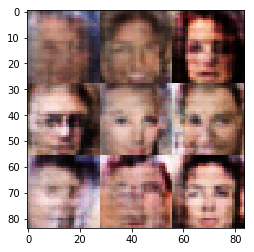

Epoch 1/1... Step: 2310... Discriminator Loss: 0.9656... Generator Loss: 0.8925
Epoch 1/1... Step: 2320... Discriminator Loss: 0.7990... Generator Loss: 1.2928
Epoch 1/1... Step: 2330... Discriminator Loss: 1.0490... Generator Loss: 0.8588
Epoch 1/1... Step: 2340... Discriminator Loss: 0.9292... Generator Loss: 1.0894
Epoch 1/1... Step: 2350... Discriminator Loss: 0.9506... Generator Loss: 1.0417
Epoch 1/1... Step: 2360... Discriminator Loss: 1.1945... Generator Loss: 0.6410
Epoch 1/1... Step: 2370... Discriminator Loss: 0.8524... Generator Loss: 1.0579
Epoch 1/1... Step: 2380... Discriminator Loss: 1.0236... Generator Loss: 0.7578
Epoch 1/1... Step: 2390... Discriminator Loss: 1.4537... Generator Loss: 0.7315
Epoch 1/1... Step: 2400... Discriminator Loss: 0.9691... Generator Loss: 0.9012
Cumulative Average Generator Loss / Discriminator Loss: 1.1505602598190308
Current Generator Loss / Discriminator Loss: 0.9299870729446411


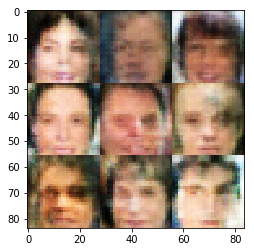

Epoch 1/1... Step: 2410... Discriminator Loss: 1.1404... Generator Loss: 0.5903
Epoch 1/1... Step: 2420... Discriminator Loss: 1.0386... Generator Loss: 0.8502
Epoch 1/1... Step: 2430... Discriminator Loss: 1.0566... Generator Loss: 0.7213
Epoch 1/1... Step: 2440... Discriminator Loss: 1.0790... Generator Loss: 0.8599
Epoch 1/1... Step: 2450... Discriminator Loss: 1.0696... Generator Loss: 0.6160
Epoch 1/1... Step: 2460... Discriminator Loss: 1.1917... Generator Loss: 0.5266
Epoch 1/1... Step: 2470... Discriminator Loss: 0.8179... Generator Loss: 1.0609
Epoch 1/1... Step: 2480... Discriminator Loss: 1.0253... Generator Loss: 0.7679
Epoch 1/1... Step: 2490... Discriminator Loss: 1.0025... Generator Loss: 1.0366
Epoch 1/1... Step: 2500... Discriminator Loss: 0.9533... Generator Loss: 0.8911
Cumulative Average Generator Loss / Discriminator Loss: 1.1338322162628174
Current Generator Loss / Discriminator Loss: 0.9347318410873413


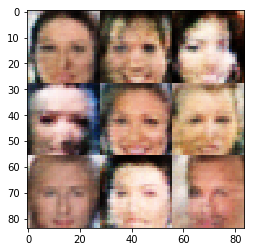

Epoch 1/1... Step: 2510... Discriminator Loss: 0.9829... Generator Loss: 0.8483
Epoch 1/1... Step: 2520... Discriminator Loss: 0.8827... Generator Loss: 1.0437
Epoch 1/1... Step: 2530... Discriminator Loss: 1.2145... Generator Loss: 0.6318
Epoch 1/1... Step: 2540... Discriminator Loss: 1.0281... Generator Loss: 0.8398
Epoch 1/1... Step: 2550... Discriminator Loss: 0.8411... Generator Loss: 1.0332
Epoch 1/1... Step: 2560... Discriminator Loss: 0.7990... Generator Loss: 1.0203
Epoch 1/1... Step: 2570... Discriminator Loss: 0.9009... Generator Loss: 1.1659
Epoch 1/1... Step: 2580... Discriminator Loss: 1.1743... Generator Loss: 0.7318
Epoch 1/1... Step: 2590... Discriminator Loss: 1.0579... Generator Loss: 0.9003
Epoch 1/1... Step: 2600... Discriminator Loss: 0.8891... Generator Loss: 0.9897
Cumulative Average Generator Loss / Discriminator Loss: 1.1263351440429688
Current Generator Loss / Discriminator Loss: 1.1131956577301025


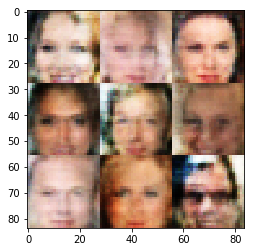

Epoch 1/1... Step: 2610... Discriminator Loss: 1.1225... Generator Loss: 0.7817
Epoch 1/1... Step: 2620... Discriminator Loss: 1.0214... Generator Loss: 0.7948
Epoch 1/1... Step: 2630... Discriminator Loss: 0.9708... Generator Loss: 0.9830
Epoch 1/1... Step: 2640... Discriminator Loss: 0.8880... Generator Loss: 1.0684
Epoch 1/1... Step: 2650... Discriminator Loss: 1.2024... Generator Loss: 0.5695
Epoch 1/1... Step: 2660... Discriminator Loss: 1.0931... Generator Loss: 0.7779
Epoch 1/1... Step: 2670... Discriminator Loss: 0.8724... Generator Loss: 0.9473
Epoch 1/1... Step: 2680... Discriminator Loss: 1.1068... Generator Loss: 0.9226
Epoch 1/1... Step: 2690... Discriminator Loss: 0.9827... Generator Loss: 0.6884
Epoch 1/1... Step: 2700... Discriminator Loss: 0.9925... Generator Loss: 1.1792
Cumulative Average Generator Loss / Discriminator Loss: 1.115435004234314
Current Generator Loss / Discriminator Loss: 1.18808913230896


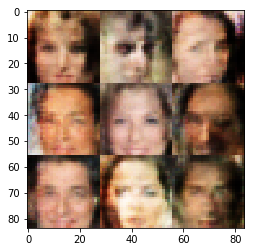

Epoch 1/1... Step: 2710... Discriminator Loss: 1.2794... Generator Loss: 0.4750
Epoch 1/1... Step: 2720... Discriminator Loss: 0.9719... Generator Loss: 0.8957
Epoch 1/1... Step: 2730... Discriminator Loss: 0.9130... Generator Loss: 0.8588
Epoch 1/1... Step: 2740... Discriminator Loss: 1.0755... Generator Loss: 0.9538
Epoch 1/1... Step: 2750... Discriminator Loss: 0.9724... Generator Loss: 1.2031
Epoch 1/1... Step: 2760... Discriminator Loss: 0.8934... Generator Loss: 1.2540
Epoch 1/1... Step: 2770... Discriminator Loss: 1.1520... Generator Loss: 0.7074
Epoch 1/1... Step: 2780... Discriminator Loss: 1.2664... Generator Loss: 0.5188
Epoch 1/1... Step: 2790... Discriminator Loss: 1.1568... Generator Loss: 0.5903
Epoch 1/1... Step: 2800... Discriminator Loss: 0.7126... Generator Loss: 1.2953
Cumulative Average Generator Loss / Discriminator Loss: 1.1049318313598633
Current Generator Loss / Discriminator Loss: 1.8176788091659546


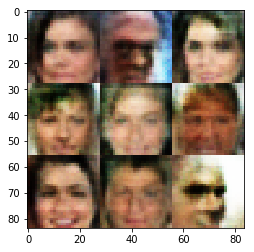

Epoch 1/1... Step: 2810... Discriminator Loss: 0.7919... Generator Loss: 1.3755
Epoch 1/1... Step: 2820... Discriminator Loss: 1.0880... Generator Loss: 0.6841
Epoch 1/1... Step: 2830... Discriminator Loss: 1.2426... Generator Loss: 0.5237
Epoch 1/1... Step: 2840... Discriminator Loss: 0.9663... Generator Loss: 0.8207
Epoch 1/1... Step: 2850... Discriminator Loss: 1.0404... Generator Loss: 0.8092
Epoch 1/1... Step: 2860... Discriminator Loss: 1.0064... Generator Loss: 0.7523
Epoch 1/1... Step: 2870... Discriminator Loss: 1.2321... Generator Loss: 0.5558
Epoch 1/1... Step: 2880... Discriminator Loss: 1.0215... Generator Loss: 0.8626
Epoch 1/1... Step: 2890... Discriminator Loss: 1.0389... Generator Loss: 1.1704
Epoch 1/1... Step: 2900... Discriminator Loss: 1.6010... Generator Loss: 0.3821
Cumulative Average Generator Loss / Discriminator Loss: 1.0898357629776
Current Generator Loss / Discriminator Loss: 0.23869198560714722


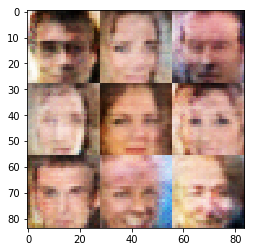

Epoch 1/1... Step: 2910... Discriminator Loss: 1.1423... Generator Loss: 0.6957
Epoch 1/1... Step: 2920... Discriminator Loss: 0.8113... Generator Loss: 1.1608
Epoch 1/1... Step: 2930... Discriminator Loss: 1.0165... Generator Loss: 0.7815
Epoch 1/1... Step: 2940... Discriminator Loss: 1.2938... Generator Loss: 0.4670
Epoch 1/1... Step: 2950... Discriminator Loss: 0.9953... Generator Loss: 0.8119
Epoch 1/1... Step: 2960... Discriminator Loss: 1.0935... Generator Loss: 0.8974
Epoch 1/1... Step: 2970... Discriminator Loss: 1.2132... Generator Loss: 0.5555
Epoch 1/1... Step: 2980... Discriminator Loss: 0.9234... Generator Loss: 1.1330
Epoch 1/1... Step: 2990... Discriminator Loss: 0.9295... Generator Loss: 0.7720
Epoch 1/1... Step: 3000... Discriminator Loss: 0.9127... Generator Loss: 0.9613
Cumulative Average Generator Loss / Discriminator Loss: 1.0794763565063477
Current Generator Loss / Discriminator Loss: 1.0531495809555054


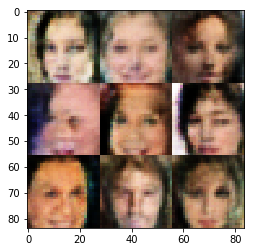

Epoch 1/1... Step: 3010... Discriminator Loss: 0.8320... Generator Loss: 1.0347
Epoch 1/1... Step: 3020... Discriminator Loss: 1.1742... Generator Loss: 0.7312
Epoch 1/1... Step: 3030... Discriminator Loss: 0.7568... Generator Loss: 1.5784
Epoch 1/1... Step: 3040... Discriminator Loss: 1.3142... Generator Loss: 0.6189
Epoch 1/1... Step: 3050... Discriminator Loss: 0.9955... Generator Loss: 0.8666
Epoch 1/1... Step: 3060... Discriminator Loss: 0.7935... Generator Loss: 1.4995
Epoch 1/1... Step: 3070... Discriminator Loss: 1.0765... Generator Loss: 0.5961
Epoch 1/1... Step: 3080... Discriminator Loss: 1.4067... Generator Loss: 0.5595
Epoch 1/1... Step: 3090... Discriminator Loss: 1.2421... Generator Loss: 0.6167
Epoch 1/1... Step: 3100... Discriminator Loss: 1.0895... Generator Loss: 0.6452
Cumulative Average Generator Loss / Discriminator Loss: 1.0702776908874512
Current Generator Loss / Discriminator Loss: 0.5922043323516846


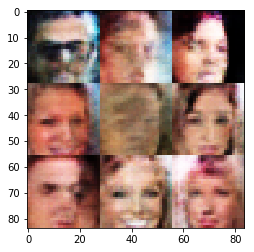

Epoch 1/1... Step: 3110... Discriminator Loss: 0.9222... Generator Loss: 0.8341
Epoch 1/1... Step: 3120... Discriminator Loss: 0.9965... Generator Loss: 1.0691
Epoch 1/1... Step: 3130... Discriminator Loss: 0.9378... Generator Loss: 1.0271
Epoch 1/1... Step: 3140... Discriminator Loss: 1.2556... Generator Loss: 0.6007
Epoch 1/1... Step: 3150... Discriminator Loss: 1.1409... Generator Loss: 0.6860
Epoch 1/1... Step: 3160... Discriminator Loss: 1.6288... Generator Loss: 0.3557


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.